In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 20

TRAIN_DIR = "../batik_dataset/train/"
TEST_DIR = "../batik_dataset/test/"

In [3]:
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 639 files belonging to 20 classes.
Found 160 files belonging to 20 classes.
Classes: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'Jawa_Barat_Megamendung', 'Jawa_Timur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'Sulawesi_Selatan_Lontara', 'Sumatera_Barat_Rumah_Minang', 'Sumatera_Utara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze backbone

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step


In [7]:
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │      5,140 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,125,588 (92.03 MB)

 Trainable params: 533,780 (2.04 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2298s 59s/step - accuracy: 0.1252 - loss: 3.5238 - val_accuracy: 0.2750 - val_loss: 2.4950
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2942 - loss: 2.5606 - val_accuracy: 0.4938 - val_loss: 1.9322
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.3912 - loss: 2.0924 - val_accuracy: 0.5875 - val_loss: 1.5803
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4695 - loss: 1.7962 - val_accuracy: 0.6625 - val_loss: 1.3399
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5681 - loss: 1.5247 - val_accuracy: 0.7000 - val_loss: 1.1866
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6166 - loss: 1.2944 - val_accuracy: 0.7375 - val_loss: 1.0589
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6401 - loss: 1.1768 - val_accuracy: 0.7500 - val_loss: 0.9768
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6714 - loss: 1.0331 - val_accuracy: 0.7750 - val_lo

In [11]:
# Unfreeze model
base_model.trainable = True

# Freeze sebagian layer (agar tidak overfitting)
# unfreeze 30 layer terakhir
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    callbacks=[early_stopping]
)


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8592 - loss: 0.4443 - val_accuracy: 0.8375 - val_loss: 0.5700
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8732 - loss: 0.4160 - val_accuracy: 0.8375 - val_loss: 0.5604
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8748 - loss: 0.4027 - val_accuracy: 0.8500 - val_loss: 0.5480
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8920 - loss: 0.3797 - val_accuracy: 0.8625 - val_loss: 0.5487
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9030 - loss: 0.3437 - val_accuracy: 0.8562 - val_loss: 0.5356
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9061 - loss: 0.3165 - val_accuracy: 0.8625 - val_loss: 0.5301
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8701 - loss: 0.3663 - val_accuracy: 0.8625 - val_loss: 0.5308
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9233 - loss: 0.2710 - val_accuracy: 0.8687 - val_loss

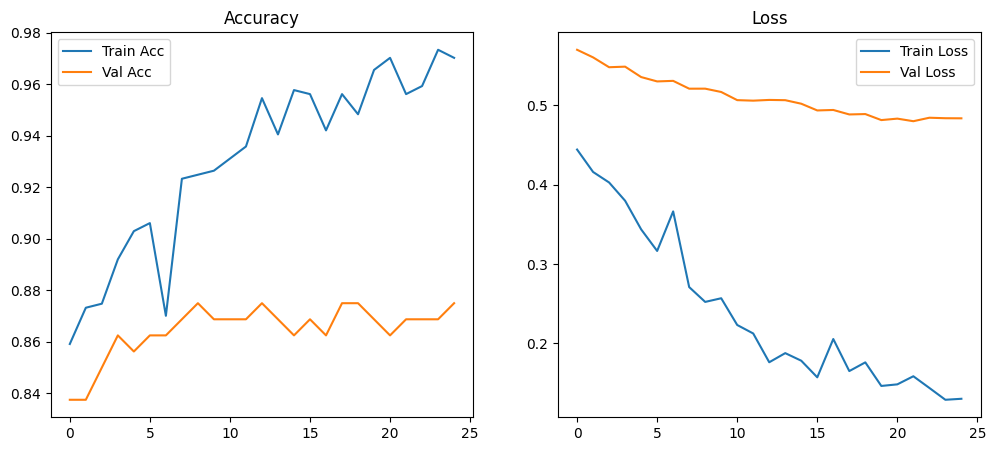

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fine_tune_history.history["accuracy"], label="Train Acc")
plt.plot(fine_tune_history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history["loss"], label="Train Loss")
plt.plot(fine_tune_history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [13]:
final_test_loss, final_test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy : {final_test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8687 - loss: 0.4800
Final Test Accuracy : 0.8687


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


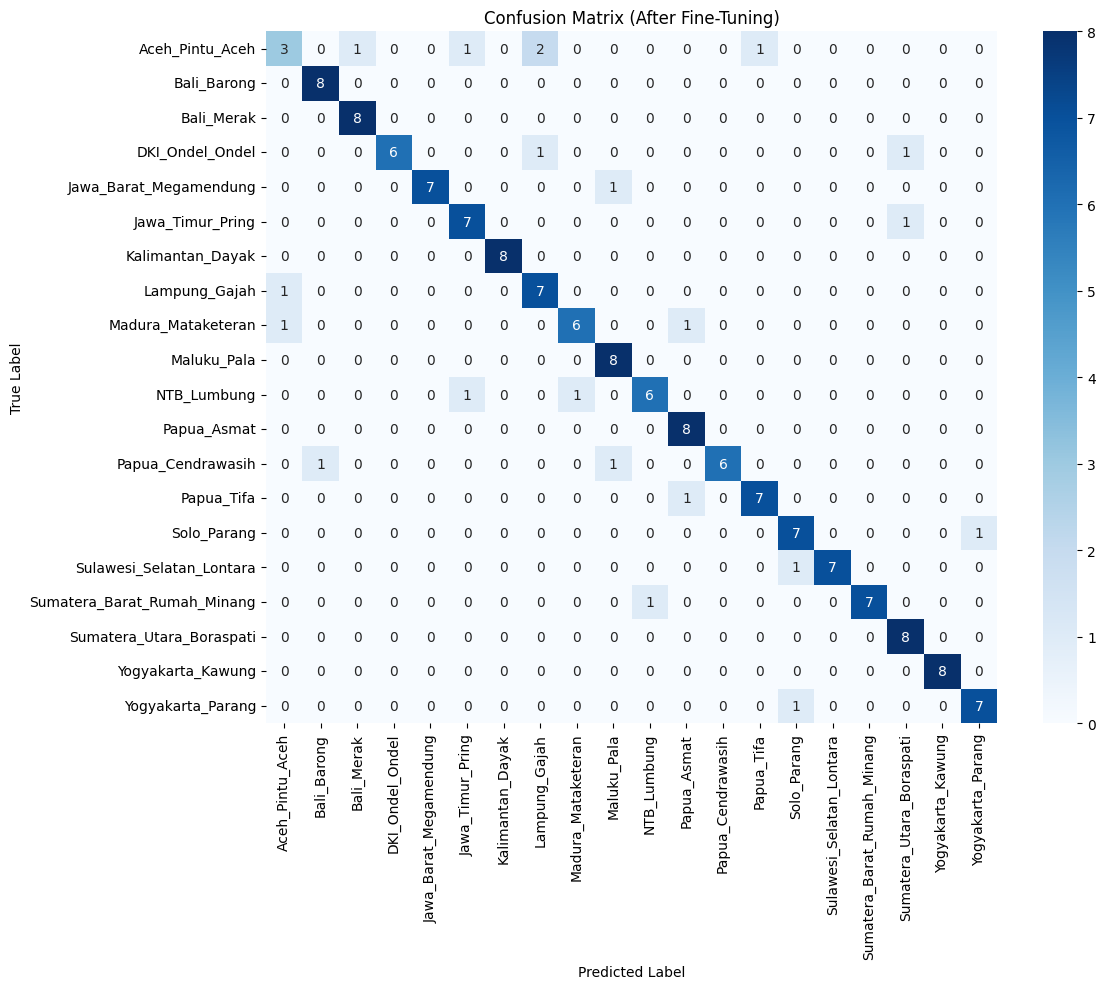

In [14]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)

    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (After Fine-Tuning)")
plt.tight_layout()
plt.show()

In [15]:
print(classification_report(y_true,y_pred,target_names=class_names))

                             precision    recall  f1-score   support

            Aceh_Pintu_Aceh       0.60      0.38      0.46         8
                Bali_Barong       0.89      1.00      0.94         8
                 Bali_Merak       0.89      1.00      0.94         8
            DKI_Ondel_Ondel       1.00      0.75      0.86         8
     Jawa_Barat_Megamendung       1.00      0.88      0.93         8
           Jawa_Timur_Pring       0.78      0.88      0.82         8
           Kalimantan_Dayak       1.00      1.00      1.00         8
              Lampung_Gajah       0.70      0.88      0.78         8
         Madura_Mataketeran       0.86      0.75      0.80         8
                Maluku_Pala       0.80      1.00      0.89         8
                NTB_Lumbung       0.86      0.75      0.80         8
                Papua_Asmat       0.80      1.00      0.89         8
          Papua_Cendrawasih       1.00      0.75      0.86         8
                 Papua_Tifa      

In [16]:
model.save("batik_classification_model.keras")